In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


In [366]:
tech = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/medium-tech-data.csv")
money = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/Medium_Money_Data_final.csv", index_col = 0) 
sports = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/medium-sports-data.csv", index_col = 0) 
politics = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/Politics_data_full.csv", index_col = 0) 

In [367]:
#there was a bug with the webscraping: people with 2020 claps have the wrong number of claps. 
#checked via website, having differing number of claps
politics = politics[politics.claps != 2020]

#get ratio of clap to followers, put as a new feature
clap_ratio = politics.claps / politics.followers

#get number of followers:
followers = politics.followers

#put the clap ratio as a new feature
politics["clap_ratio"] = clap_ratio



In [368]:
#cleaning the data - removing nulls and empty vals
tech = tech[pd.notnull(tech['text'])]
tech.reset_index(inplace = True)

sports = sports[pd.notnull(sports['text'])]
sports.reset_index(inplace = True)

politics = politics[pd.notnull(politics['text'])]
politics.reset_index(inplace = True)

money = money[pd.notnull(money['text'])] 
money.reset_index(inplace = True)

politics = politics[~(politics.text == '[]')]
money = money[~(money.text == '[]')]
sports = sports[~(sports.text == '[]')]
tech = tech[~(tech.text == '[]')]

#shuffle and randomly select 2000 entries (downsampling tech and politics) (money keep at 1600) (sports keep at 2500)
t = tech.sample(2000, replace= False)[["text"]].reset_index(drop=True)
s = sports.sample(len(sports), replace= False)[["text"]].reset_index(drop=True)
p = politics.sample(2000, replace= False)[["text"]].reset_index(drop=True)
m = money.sample(len(money), replace= False)[["text"]].reset_index(drop=True)

In [369]:
#Breaking our data up into training and test sets (80/20 split)
pd.options.mode.chained_assignment = None #surpress warning

#first, we need to add the labels
t["label"] = [0] * len(t)
s["label"] = [1] * len(s)
p["label"] = [2] * len(p)
m["label"] = [3] * len(m)

#store index of 80/20 split
ind_t = int(len(t) * 0.8)
ind_s = int(len(s) * 0.8)
ind_p = int(len(p) * 0.8)
ind_m = int(len(m) * 0.8)

#making the training set and test sets
t_train = t.iloc[:ind_t] 
s_train = s.iloc[:ind_s] 
p_train = p.iloc[:ind_p] 
m_train = t.iloc[:ind_m] 

t_test = t.iloc[ind_t:] 
s_test = s.iloc[ind_s:] 
p_test = p.iloc[ind_p:] 
m_test = t.iloc[ind_m:] 

In [370]:
#combining all the topics into train and test
ts = pd.concat([t_train, s_train], axis = 0)
pm = pd.concat([p_train, m_train], axis = 0)
train = pd.concat([ts, pm], axis = 0)

ts_test = pd.concat([t_test, s_test], axis = 0)
pm_test = pd.concat([p_test, m_test], axis = 0)
test = pd.concat([ts_test, pm_test], axis = 0)

In [371]:
#shuffling
train = train.sample(frac = 1, replace = False).reset_index(drop=True)
test = test.sample(frac = 1, replace = False).reset_index(drop=True)

#get X and Y data from the sets
X_train = train.text
Y_train = train.label

X_test = test.text
Y_test = test.label


In [372]:
train.head()

,text,label
0,This is “What’s on Your Home Screen?” a Q&A co...,0
1,Kyler Murray made waves over the summer when h...,1
2,"Ding, ding, ding! It’s Friday night in the bri...",1
3,"['[Of Macroeconomics, Social Security, and the...",2
4,['[In my previous article published on Medium ...,2


In [373]:
#create the vector
#focus on max_features as well
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 50)

#fit the data
vector.fit(X_train)

#look at the vectorizer
print(vector.get_feature_names())


['american', 'best', 'better', 'change', 'country', 'day', 'did', 'does', 'dont', 'game', 'going', 'good', 'government', 'just', 'know', 'life', 'like', 'long', 'make', 'media', 'need', 'new', 'people', 'players', 'point', 'political', 'power', 'president', 'public', 'right', 'said', 'say', 'season', 'social', 'state', 'states', 'team', 'thats', 'things', 'think', 'time', 'trump', 'united', 'want', 'way', 'white', 'work', 'world', 'year', 'years']


In [374]:
#transforming the data, manipulating it based on the weights we 
#determined before by fitting our data 
train_transformed = vector.transform(X_train)
test_transformed = vector.transform(X_test)

#splitting
train_test_split(train_transformed, Y_train)[0], train_test_split(train_transformed, Y_train)[1]

(<4902x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 48836 stored elements in Compressed Sparse Row format>,
 <1635x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 16542 stored elements in Compressed Sparse Row format>)

In [380]:
#create the KNN model
knearest = knn(n_neighbors = 5)

#fit the model with training data
knearest.fit(train_transformed, Y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [381]:
knearest.score(test_transformed, Y_test)

0.755533199195171

# Hyperparameter Tuning and Cross Validation

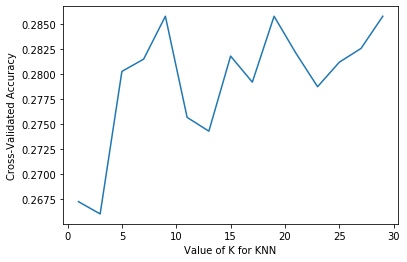

In [383]:
#Cross Validation for k

# creating odd list of k for KNN (to prevent ties)
neighbors = list(range(1, 31, 2))
# empty list that will hold cv scores
cv_scores = []


# perform 5-fold cross validation
for k in neighbors:
    knearest = knn(n_neighbors = k)
    scores = cross_val_score(knearest, train_transformed, Y_training, cv = 5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# plot of accuracies for different k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [ ]:
#Trying different k values
knn_scores = []

for i in range(30):
    knearest = knn(n_neighbors = i+1)
    knearest.fit(train_transformed, Y_training)
    
    knn_scores.append(knearest.score(test_transformed, Y_test))

In [317]:
knn_scores.index(max(knn_scores))+1

18

# Analysis

In [ ]:
Clusters?
Suprevised and Unsuprevised - clarify
confusion matrix?